# SatCLIP Deep Dive: Interpolation, Ecoregions, MLP & Visualization

This notebook continues our investigation with 4 experiments:
1. **Spatial Interpolation** - Task where L=40 should outperform L=10
2. **Ecoregion Classification** - Real-world multi-level classification
3. **MLP vs Logistic Regression** - Does a more complex classifier help?
4. **t-SNE/UMAP Visualization** - Understand embedding structure

For best performance, use `Runtime -> Change runtime type -> T4 GPU`

## 1. Setup

In [1]:
# Clone SatCLIP repository (only needed in Colab)
import os
if 'COLAB_GPU' in os.environ:
    !rm -rf sample_data .config satclip 2>/dev/null
    !git clone https://github.com/1hamzaiqbal/satclip.git

Cloning into 'satclip'...
remote: Enumerating objects: 308, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 308 (delta 98), reused 94 (delta 90), pack-reused 187 (from 2)
Receiving objects: 100% (308/308), 77.20 MiB | 22.96 MiB/s, done.
Resolving deltas: 100% (126/126), done.
Updating files: 100% (82/82), done.


In [2]:
# Install dependencies
!pip install lightning --quiet
!pip install rasterio --quiet
!pip install torchgeo --quiet
!pip install huggingface_hub --quiet
!pip install umap-learn --quiet
!pip install geopandas --quiet
!pip install shapely --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.8/241.8 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import sys
import os

# Handle path for both Colab and local execution
if 'COLAB_GPU' in os.environ:
    sys.path.append('./satclip/satclip')
else:
    sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'satclip'))

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from load import get_satclip
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Using device: cuda


In [4]:
# Load both models
print("Loading L=10 model...")
model_l10 = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ViT16-L10", "satclip-vit16-l10.ckpt"),
    device=device,
)
model_l10.eval()
print("L=10 model loaded!")

print("\nLoading L=40 model...")
model_l40 = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ViT16-L40", "satclip-vit16-l40.ckpt"),
    device=device,
)
model_l40.eval()
print("L=40 model loaded!")

Loading L=10 model...


satclip-vit16-l10.ckpt:   0%|          | 0.00/103M [00:00<?, ?B/s]

using pretrained moco vit16
Downloading: "https://hf.co/torchgeo/vit_small_patch16_224_sentinel2_all_moco/resolve/1cb683f6c14739634cdfaaceb076529adf898c74/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth" to /root/.cache/torch/hub/checkpoints/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth


100%|██████████| 86.5M/86.5M [00:00<00:00, 188MB/s]


L=10 model loaded!

Loading L=40 model...


satclip-vit16-l40.ckpt:   0%|          | 0.00/121M [00:00<?, ?B/s]

using pretrained moco vit16
L=40 model loaded!


---
## 2. Spatial Interpolation Task (L=40 Should Win)

**Key insight from paper**: L=40 is better at predicting values at locations *between* training points.

**Design**: Create a continuous function over space, train on a grid of points, predict at points *between* grid cells. This tests interpolation ability.

In [5]:
def create_interpolation_dataset(grid_spacing_deg=5, noise_std=0.1, bounds=(-120, -70, 25, 50)):
    """
    Create a spatial interpolation task over the continental US.

    Training: Regular grid of points
    Testing: Points at the CENTER of each grid cell (interpolation)
    Target: A smooth spatial function (latitude + some spatial variation)
    """
    lon_min, lon_max, lat_min, lat_max = bounds

    # Create training grid
    train_lons = np.arange(lon_min, lon_max + grid_spacing_deg, grid_spacing_deg)
    train_lats = np.arange(lat_min, lat_max + grid_spacing_deg, grid_spacing_deg)
    train_lon_grid, train_lat_grid = np.meshgrid(train_lons, train_lats)
    train_coords = np.stack([train_lon_grid.flatten(), train_lat_grid.flatten()], axis=1)

    # Create test points at CENTER of each grid cell (interpolation points)
    test_lons = train_lons[:-1] + grid_spacing_deg / 2
    test_lats = train_lats[:-1] + grid_spacing_deg / 2
    test_lon_grid, test_lat_grid = np.meshgrid(test_lons, test_lats)
    test_coords = np.stack([test_lon_grid.flatten(), test_lat_grid.flatten()], axis=1)

    # Target function: latitude normalized + spatial wave pattern
    def target_function(lon, lat):
        # Normalize latitude to [0, 1]
        lat_norm = (lat - lat_min) / (lat_max - lat_min)
        # Add spatial wave pattern
        wave = 0.2 * np.sin(np.radians(lon) * 3) * np.cos(np.radians(lat) * 2)
        return lat_norm + wave

    train_y = target_function(train_coords[:, 0], train_coords[:, 1])
    test_y = target_function(test_coords[:, 0], test_coords[:, 1])

    # Add noise to training targets
    train_y += np.random.normal(0, noise_std, len(train_y))

    return (
        torch.tensor(train_coords).double(),
        torch.tensor(train_y).float(),
        torch.tensor(test_coords).double(),
        torch.tensor(test_y).float()
    )

# Create dataset with different grid spacings
print("Testing interpolation at different grid spacings...\n")
print(f"{'Grid Spacing':>12} | {'L=10 R²':>10} | {'L=40 R²':>10} | {'Winner':>10}")
print("-" * 52)

grid_spacings = [10, 5, 2, 1]  # degrees
results_interp = {'spacing': [], 'l10_r2': [], 'l40_r2': []}

for spacing in grid_spacings:
    train_coords, train_y, test_coords, test_y = create_interpolation_dataset(
        grid_spacing_deg=spacing, noise_std=0.05
    )

    # Get embeddings
    with torch.no_grad():
        train_emb_l10 = model_l10(train_coords.to(device)).cpu().numpy()
        train_emb_l40 = model_l40(train_coords.to(device)).cpu().numpy()
        test_emb_l10 = model_l10(test_coords.to(device)).cpu().numpy()
        test_emb_l40 = model_l40(test_coords.to(device)).cpu().numpy()

    # Train simple linear regressors
    from sklearn.linear_model import Ridge

    reg_l10 = Ridge(alpha=1.0)
    reg_l10.fit(train_emb_l10, train_y.numpy())
    pred_l10 = reg_l10.predict(test_emb_l10)
    r2_l10 = r2_score(test_y.numpy(), pred_l10)

    reg_l40 = Ridge(alpha=1.0)
    reg_l40.fit(train_emb_l40, train_y.numpy())
    pred_l40 = reg_l40.predict(test_emb_l40)
    r2_l40 = r2_score(test_y.numpy(), pred_l40)

    winner = "L=40" if r2_l40 > r2_l10 + 0.01 else ("L=10" if r2_l10 > r2_l40 + 0.01 else "~Same")
    print(f"{spacing:>10}° | {r2_l10:>10.4f} | {r2_l40:>10.4f} | {winner:>10}")

    results_interp['spacing'].append(spacing)
    results_interp['l10_r2'].append(r2_l10)
    results_interp['l40_r2'].append(r2_l40)

Testing interpolation at different grid spacings...

Grid Spacing |    L=10 R² |    L=40 R² |     Winner
----------------------------------------------------
        10° |     0.9557 |    -0.1647 |       L=10
         5° |     0.9742 |     0.7797 |       L=10
         2° |     0.9964 |     0.9489 |       L=10
         1° |     0.9987 |     0.9804 |       L=10


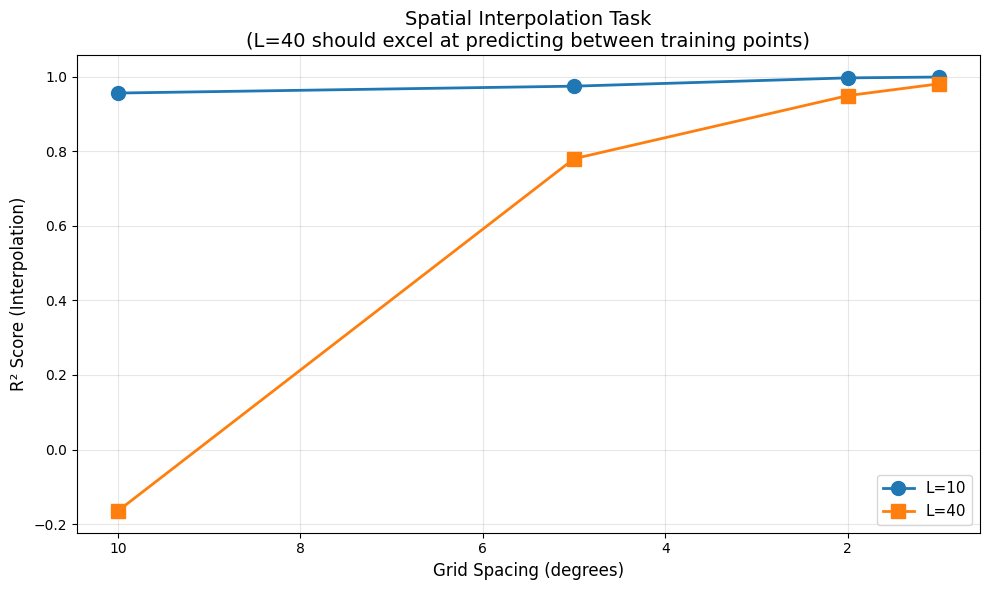


Interpretation:
- This tests interpolation (predicting between known points)
- Per the paper, L=40 should perform better here


In [6]:
# Visualize interpolation results
plt.figure(figsize=(10, 6))
plt.plot(results_interp['spacing'], results_interp['l10_r2'], 'o-', label='L=10', linewidth=2, markersize=10)
plt.plot(results_interp['spacing'], results_interp['l40_r2'], 's-', label='L=40', linewidth=2, markersize=10)
plt.xlabel('Grid Spacing (degrees)', fontsize=12)
plt.ylabel('R² Score (Interpolation)', fontsize=12)
plt.title('Spatial Interpolation Task\n(L=40 should excel at predicting between training points)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()  # Smaller spacing = harder task
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- This tests interpolation (predicting between known points)")
print("- Per the paper, L=40 should perform better here")

---
## 3. Ecoregion Classification

Test with real WWF Ecoregions data at different hierarchy levels.

In [7]:
# Download WWF Ecoregions shapefile
import geopandas as gpd
from shapely.geometry import Point

# Try to load ecoregions - use a simplified approach with direct download
print("Loading WWF Ecoregions data...")

try:
    # Try loading from a GeoJSON source (more reliable than shapefile)
    ecoregions_url = "https://raw.githubusercontent.com/Resolve-Collective/wwf-ecoregions/main/data/wwf_terr_ecos.geojson"
    ecoregions = gpd.read_file(ecoregions_url)
    print(f"Loaded {len(ecoregions)} ecoregions")
    print(f"Columns: {list(ecoregions.columns)}")
except Exception as e:
    print(f"Could not load from URL: {e}")
    print("\nUsing synthetic ecoregion-like data instead...")
    ecoregions = None

Loading WWF Ecoregions data...
Could not load from URL: HTTP Error 404: Not Found

Using synthetic ecoregion-like data instead...


In [8]:
def sample_points_with_ecoregions(ecoregions_gdf, n_samples=5000, seed=42):
    """
    Sample random points and assign ecoregion labels.
    """
    np.random.seed(seed)

    # Sample from land bounds
    lons = np.random.uniform(-180, 180, n_samples * 3)
    lats = np.random.uniform(-60, 70, n_samples * 3)

    points = gpd.GeoDataFrame(
        geometry=[Point(lon, lat) for lon, lat in zip(lons, lats)],
        crs=ecoregions_gdf.crs
    )

    # Spatial join to get ecoregion for each point
    joined = gpd.sjoin(points, ecoregions_gdf, how='inner', predicate='within')

    # Take first n_samples
    joined = joined.head(n_samples)

    coords = np.array([[p.x, p.y] for p in joined.geometry])

    return coords, joined

if ecoregions is not None:
    # Identify the column names for different hierarchy levels
    print("\nEcoregion columns:")
    for col in ecoregions.columns:
        if ecoregions[col].dtype == 'object':
            n_unique = ecoregions[col].nunique()
            print(f"  {col}: {n_unique} unique values")

In [9]:
if ecoregions is not None:
    print("Sampling points with ecoregion labels...")
    coords, joined_df = sample_points_with_ecoregions(ecoregions, n_samples=5000)
    print(f"Sampled {len(coords)} points with ecoregion labels")

    # Identify hierarchy columns (adjust based on actual column names)
    # Common names: BIOME, ECO_NAME, REALM, etc.
    hierarchy_cols = []
    for col in ['BIOME', 'REALM', 'ECO_NAME', 'BIOME_NAME']:
        if col in joined_df.columns:
            hierarchy_cols.append(col)

    if not hierarchy_cols:
        # Find columns with categorical data
        for col in joined_df.columns:
            if joined_df[col].dtype == 'object' and col != 'geometry':
                n_unique = joined_df[col].nunique()
                if 5 <= n_unique <= 500:
                    hierarchy_cols.append(col)
        hierarchy_cols = hierarchy_cols[:3]  # Take up to 3

    print(f"Using hierarchy columns: {hierarchy_cols}")
else:
    print("Skipping ecoregion test (data not available)")
    hierarchy_cols = []

Skipping ecoregion test (data not available)


In [10]:
if ecoregions is not None and len(hierarchy_cols) > 0:
    print("\nEcoregion Classification Results:")
    print(f"{'Level':>20} | {'# Classes':>10} | {'L=10 Acc':>10} | {'L=40 Acc':>10} | {'Winner':>10}")
    print("-" * 70)

    coords_tensor = torch.tensor(coords).double()

    with torch.no_grad():
        emb_l10 = model_l10(coords_tensor.to(device)).cpu().numpy()
        emb_l40 = model_l40(coords_tensor.to(device)).cpu().numpy()

    ecoregion_results = []

    for col in hierarchy_cols:
        labels = joined_df[col].values
        le = LabelEncoder()
        y = le.fit_transform(labels)
        n_classes = len(le.classes_)

        # Skip if too few classes or too many
        if n_classes < 3 or n_classes > 300:
            continue

        # Split data
        X_train_l10, X_test_l10, y_train, y_test = train_test_split(
            emb_l10, y, test_size=0.3, random_state=42, stratify=y
        )
        X_train_l40, X_test_l40, _, _ = train_test_split(
            emb_l40, y, test_size=0.3, random_state=42, stratify=y
        )

        # Train classifiers
        clf_l10 = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
        clf_l10.fit(X_train_l10, y_train)
        acc_l10 = accuracy_score(y_test, clf_l10.predict(X_test_l10))

        clf_l40 = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
        clf_l40.fit(X_train_l40, y_train)
        acc_l40 = accuracy_score(y_test, clf_l40.predict(X_test_l40))

        winner = "L=40" if acc_l40 > acc_l10 + 0.01 else ("L=10" if acc_l10 > acc_l40 + 0.01 else "~Same")
        print(f"{col:>20} | {n_classes:>10} | {acc_l10:>10.2%} | {acc_l40:>10.2%} | {winner:>10}")

        ecoregion_results.append({
            'level': col,
            'n_classes': n_classes,
            'l10_acc': acc_l10,
            'l40_acc': acc_l40
        })

---
## 4. MLP vs Logistic Regression (Checkerboard Revisited)

Does a more powerful classifier help extract finer-grained spatial information?

In [11]:
def create_checkerboard_dataset(cell_size_deg, n_samples=5000, bounds=(-180, 180, -60, 60)):
    """
    Create a checkerboard classification dataset.
    """
    lon_min, lon_max, lat_min, lat_max = bounds

    lons = np.random.uniform(lon_min, lon_max, n_samples)
    lats = np.random.uniform(lat_min, lat_max, n_samples)

    cell_x = (lons / cell_size_deg).astype(int)
    cell_y = (lats / cell_size_deg).astype(int)
    labels = (cell_x + cell_y) % 2

    coords = torch.tensor(np.stack([lons, lats], axis=1)).double()
    labels = torch.tensor(labels).long()

    return coords, labels

def evaluate_checkerboard_with_classifiers(model, cell_size_deg, n_samples=5000):
    """
    Evaluate with both Logistic Regression and MLP.
    """
    coords, labels = create_checkerboard_dataset(cell_size_deg, n_samples)

    with torch.no_grad():
        embeddings = model(coords.to(device)).cpu().numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels.numpy(), test_size=0.3, random_state=42
    )

    # Logistic Regression
    clf_lr = LogisticRegression(max_iter=1000, random_state=42)
    clf_lr.fit(X_train, y_train)
    acc_lr = accuracy_score(y_test, clf_lr.predict(X_test))

    # MLP (2 hidden layers)
    clf_mlp = MLPClassifier(
        hidden_layer_sizes=(128, 64),
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )
    clf_mlp.fit(X_train, y_train)
    acc_mlp = accuracy_score(y_test, clf_mlp.predict(X_test))

    return acc_lr, acc_mlp

# Test different cell sizes
cell_sizes = [45, 20, 10, 5, 2, 1, 0.5]
approx_km = [c * 111 for c in cell_sizes]

print("Comparing Logistic Regression vs MLP on Checkerboard Task")
print("\nL=10 Model:")
print(f"{'Cell Size':>10} | {'≈ km':>8} | {'LogReg':>10} | {'MLP':>10} | {'Improvement':>12}")
print("-" * 60)

mlp_results = {'cell_size': [], 'l10_lr': [], 'l10_mlp': [], 'l40_lr': [], 'l40_mlp': []}

for cell_size, km in zip(cell_sizes, approx_km):
    acc_lr, acc_mlp = evaluate_checkerboard_with_classifiers(model_l10, cell_size, n_samples=4000)
    improvement = acc_mlp - acc_lr
    print(f"{cell_size:>8.1f}° | {km:>7.0f} | {acc_lr:>10.2%} | {acc_mlp:>10.2%} | {improvement:>+11.2%}")
    mlp_results['cell_size'].append(cell_size)
    mlp_results['l10_lr'].append(acc_lr)
    mlp_results['l10_mlp'].append(acc_mlp)

Comparing Logistic Regression vs MLP on Checkerboard Task

L=10 Model:
 Cell Size |     ≈ km |     LogReg |        MLP |  Improvement
------------------------------------------------------------
    45.0° |    4995 |     94.17% |     96.08% |      +1.92%
    20.0° |    2220 |     80.25% |     92.58% |     +12.33%
    10.0° |    1110 |     55.58% |     68.92% |     +13.33%
     5.0° |     555 |     48.25% |     51.25% |      +3.00%
     2.0° |     222 |     48.75% |     49.33% |      +0.58%
     1.0° |     111 |     50.00% |     48.67% |      -1.33%
     0.5° |      56 |     49.83% |     49.50% |      -0.33%


In [12]:
print("\nL=40 Model:")
print(f"{'Cell Size':>10} | {'≈ km':>8} | {'LogReg':>10} | {'MLP':>10} | {'Improvement':>12}")
print("-" * 60)

for i, (cell_size, km) in enumerate(zip(cell_sizes, approx_km)):
    acc_lr, acc_mlp = evaluate_checkerboard_with_classifiers(model_l40, cell_size, n_samples=4000)
    improvement = acc_mlp - acc_lr
    print(f"{cell_size:>8.1f}° | {km:>7.0f} | {acc_lr:>10.2%} | {acc_mlp:>10.2%} | {improvement:>+11.2%}")
    mlp_results['l40_lr'].append(acc_lr)
    mlp_results['l40_mlp'].append(acc_mlp)


L=40 Model:
 Cell Size |     ≈ km |     LogReg |        MLP |  Improvement
------------------------------------------------------------
    45.0° |    4995 |     63.33% |     78.92% |     +15.58%
    20.0° |    2220 |     58.92% |     71.83% |     +12.92%
    10.0° |    1110 |     56.92% |     64.92% |      +8.00%
     5.0° |     555 |     51.42% |     58.00% |      +6.58%
     2.0° |     222 |     50.25% |     49.58% |      -0.67%
     1.0° |     111 |     50.83% |     48.42% |      -2.42%
     0.5° |      56 |     48.33% |     49.08% |      +0.75%


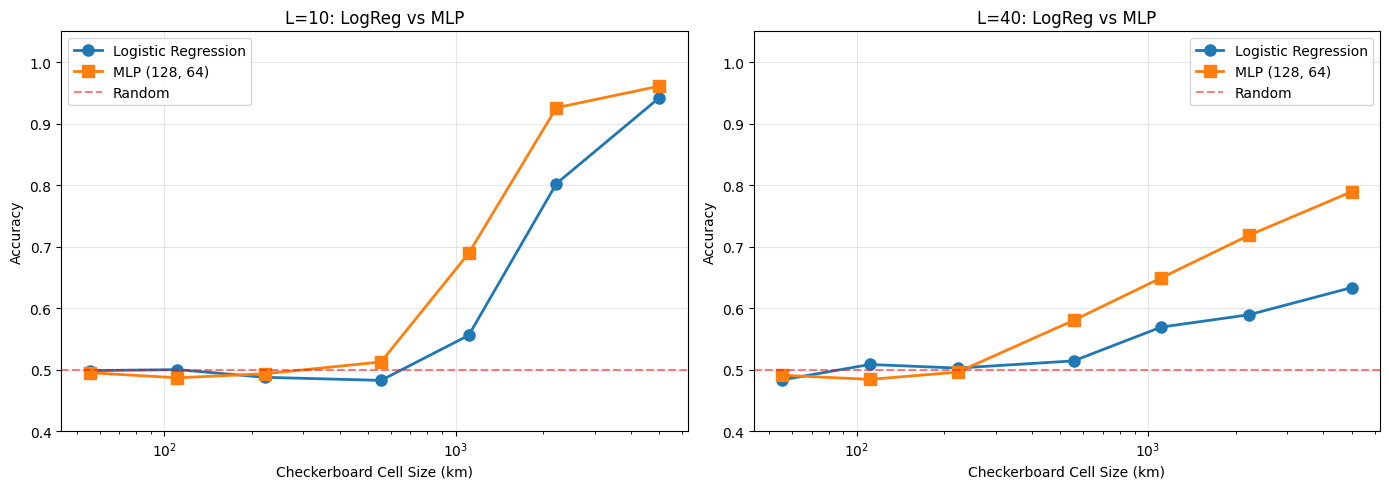


Key Question: Does MLP help extract finer spatial information from embeddings?


In [13]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# L=10
axes[0].plot(approx_km, mlp_results['l10_lr'], 'o-', label='Logistic Regression', linewidth=2, markersize=8)
axes[0].plot(approx_km, mlp_results['l10_mlp'], 's-', label='MLP (128, 64)', linewidth=2, markersize=8)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
axes[0].set_xscale('log')
axes[0].set_xlabel('Checkerboard Cell Size (km)')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('L=10: LogReg vs MLP')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0.4, 1.05)

# L=40
axes[1].plot(approx_km, mlp_results['l40_lr'], 'o-', label='Logistic Regression', linewidth=2, markersize=8)
axes[1].plot(approx_km, mlp_results['l40_mlp'], 's-', label='MLP (128, 64)', linewidth=2, markersize=8)
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
axes[1].set_xscale('log')
axes[1].set_xlabel('Checkerboard Cell Size (km)')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('L=40: LogReg vs MLP')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0.4, 1.05)

plt.tight_layout()
plt.show()

print("\nKey Question: Does MLP help extract finer spatial information from embeddings?")

---
## 5. t-SNE/UMAP Visualization

Visualize the embedding space to understand its structure.

In [14]:
from sklearn.manifold import TSNE
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("UMAP not available, using t-SNE only")

# Sample locations from around the world
np.random.seed(42)
n_viz = 2000

# Sample with geographic clustering for visualization
viz_lons = np.random.uniform(-180, 180, n_viz)
viz_lats = np.random.uniform(-60, 70, n_viz)
viz_coords = torch.tensor(np.stack([viz_lons, viz_lats], axis=1)).double()

# Get embeddings
with torch.no_grad():
    viz_emb_l10 = model_l10(viz_coords.to(device)).cpu().numpy()
    viz_emb_l40 = model_l40(viz_coords.to(device)).cpu().numpy()

print(f"Generated embeddings for {n_viz} locations")

Generated embeddings for 2000 locations


In [15]:
# Run dimensionality reduction
print("Running t-SNE for L=10...")
tsne_l10 = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
viz_2d_l10_tsne = tsne_l10.fit_transform(viz_emb_l10)

print("Running t-SNE for L=40...")
tsne_l40 = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
viz_2d_l40_tsne = tsne_l40.fit_transform(viz_emb_l40)

if HAS_UMAP:
    print("Running UMAP for L=10...")
    umap_l10 = umap.UMAP(n_components=2, random_state=42)
    viz_2d_l10_umap = umap_l10.fit_transform(viz_emb_l10)

    print("Running UMAP for L=40...")
    umap_l40 = umap.UMAP(n_components=2, random_state=42)
    viz_2d_l40_umap = umap_l40.fit_transform(viz_emb_l40)

print("Done!")

Running t-SNE for L=10...
Running t-SNE for L=40...
Running UMAP for L=10...
Running UMAP for L=40...
Done!


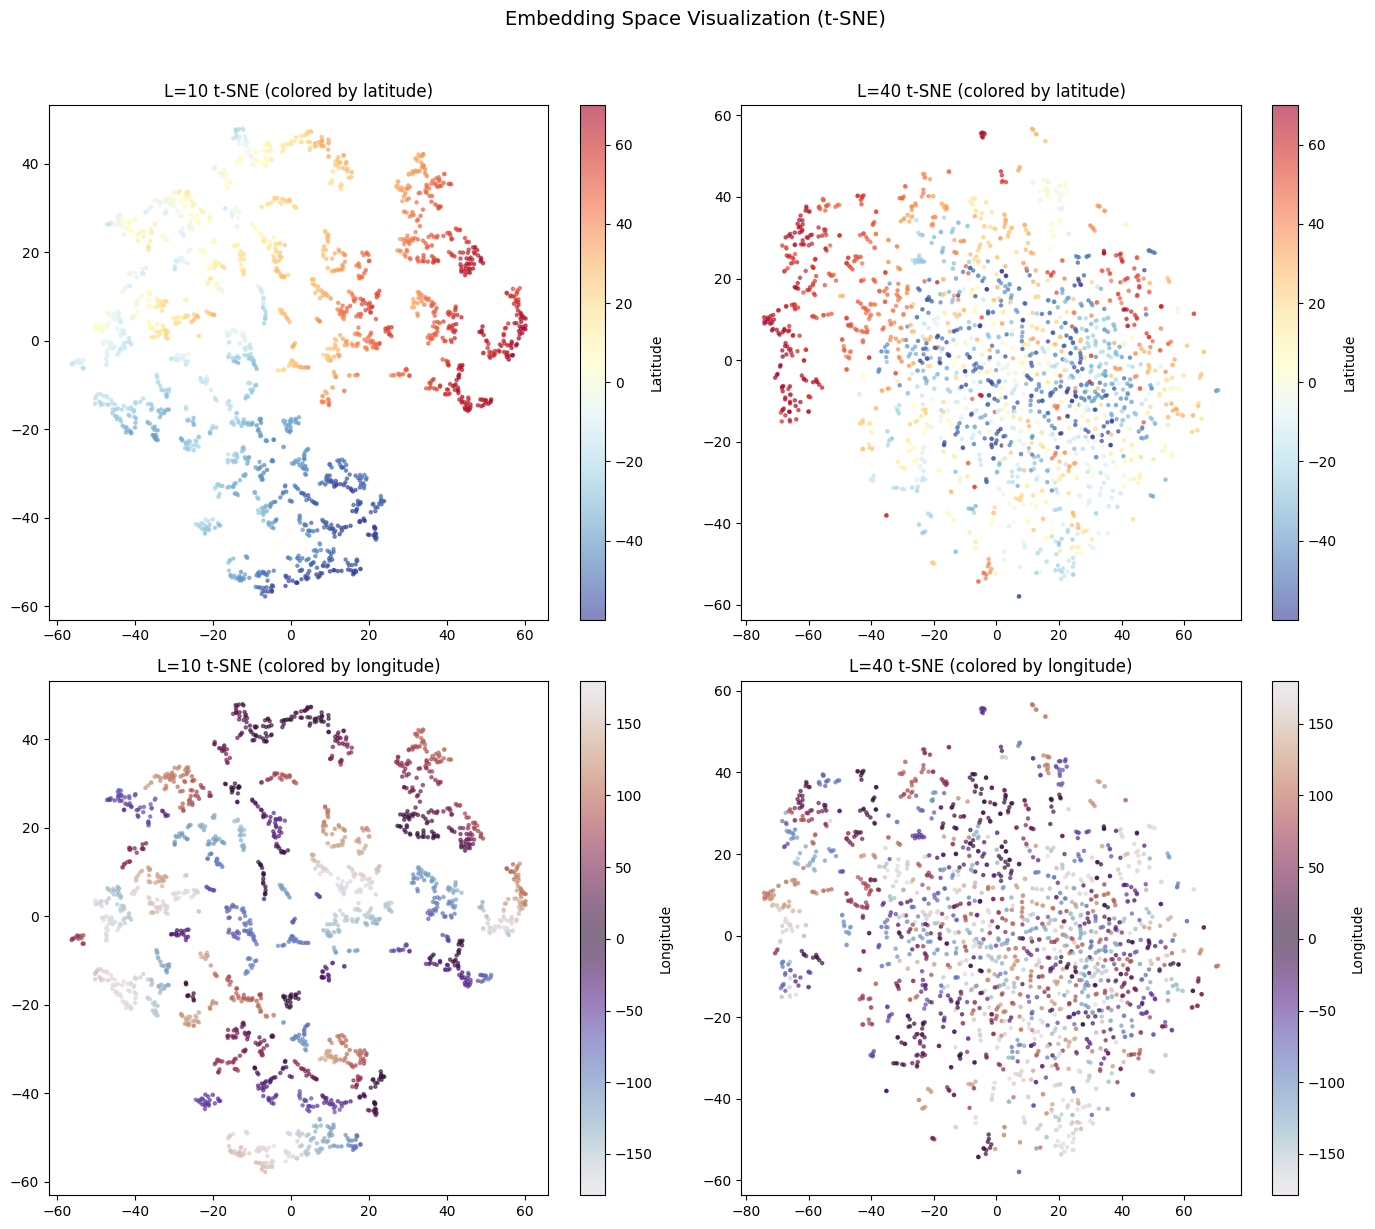

In [16]:
# Visualize - colored by latitude (should show gradient if embeddings capture geography)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# t-SNE L=10 - colored by latitude
sc1 = axes[0, 0].scatter(viz_2d_l10_tsne[:, 0], viz_2d_l10_tsne[:, 1],
                          c=viz_lats, cmap='RdYlBu_r', s=5, alpha=0.6)
axes[0, 0].set_title('L=10 t-SNE (colored by latitude)')
plt.colorbar(sc1, ax=axes[0, 0], label='Latitude')

# t-SNE L=40 - colored by latitude
sc2 = axes[0, 1].scatter(viz_2d_l40_tsne[:, 0], viz_2d_l40_tsne[:, 1],
                          c=viz_lats, cmap='RdYlBu_r', s=5, alpha=0.6)
axes[0, 1].set_title('L=40 t-SNE (colored by latitude)')
plt.colorbar(sc2, ax=axes[0, 1], label='Latitude')

# t-SNE L=10 - colored by longitude
sc3 = axes[1, 0].scatter(viz_2d_l10_tsne[:, 0], viz_2d_l10_tsne[:, 1],
                          c=viz_lons, cmap='twilight', s=5, alpha=0.6)
axes[1, 0].set_title('L=10 t-SNE (colored by longitude)')
plt.colorbar(sc3, ax=axes[1, 0], label='Longitude')

# t-SNE L=40 - colored by longitude
sc4 = axes[1, 1].scatter(viz_2d_l40_tsne[:, 0], viz_2d_l40_tsne[:, 1],
                          c=viz_lons, cmap='twilight', s=5, alpha=0.6)
axes[1, 1].set_title('L=40 t-SNE (colored by longitude)')
plt.colorbar(sc4, ax=axes[1, 1], label='Longitude')

plt.suptitle('Embedding Space Visualization (t-SNE)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

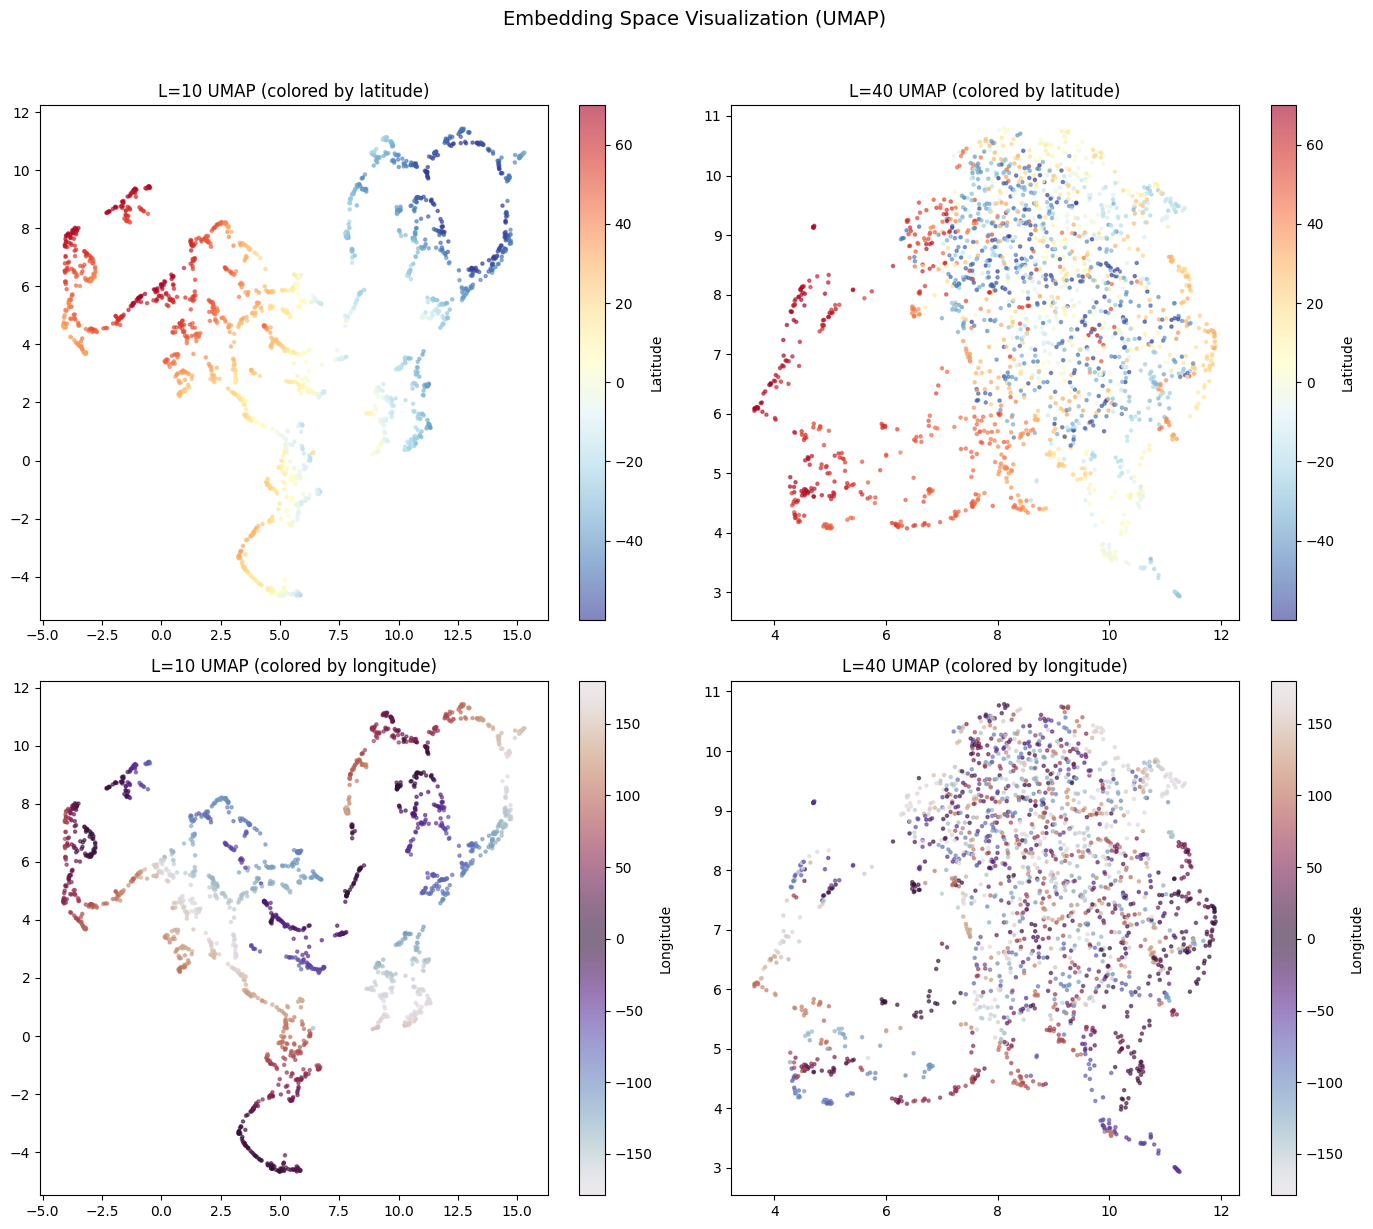

In [17]:
if HAS_UMAP:
    # UMAP visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # UMAP L=10 - colored by latitude
    sc1 = axes[0, 0].scatter(viz_2d_l10_umap[:, 0], viz_2d_l10_umap[:, 1],
                              c=viz_lats, cmap='RdYlBu_r', s=5, alpha=0.6)
    axes[0, 0].set_title('L=10 UMAP (colored by latitude)')
    plt.colorbar(sc1, ax=axes[0, 0], label='Latitude')

    # UMAP L=40 - colored by latitude
    sc2 = axes[0, 1].scatter(viz_2d_l40_umap[:, 0], viz_2d_l40_umap[:, 1],
                              c=viz_lats, cmap='RdYlBu_r', s=5, alpha=0.6)
    axes[0, 1].set_title('L=40 UMAP (colored by latitude)')
    plt.colorbar(sc2, ax=axes[0, 1], label='Latitude')

    # UMAP L=10 - colored by longitude
    sc3 = axes[1, 0].scatter(viz_2d_l10_umap[:, 0], viz_2d_l10_umap[:, 1],
                              c=viz_lons, cmap='twilight', s=5, alpha=0.6)
    axes[1, 0].set_title('L=10 UMAP (colored by longitude)')
    plt.colorbar(sc3, ax=axes[1, 0], label='Longitude')

    # UMAP L=40 - colored by longitude
    sc4 = axes[1, 1].scatter(viz_2d_l40_umap[:, 0], viz_2d_l40_umap[:, 1],
                              c=viz_lons, cmap='twilight', s=5, alpha=0.6)
    axes[1, 1].set_title('L=40 UMAP (colored by longitude)')
    plt.colorbar(sc4, ax=axes[1, 1], label='Longitude')

    plt.suptitle('Embedding Space Visualization (UMAP)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

---
## 6. Summary

In [18]:
print("="*70)
print("EXPERIMENT SUMMARY")
print("="*70)

print("\n1. SPATIAL INTERPOLATION TASK")
print("-" * 40)
if results_interp['l10_r2']:
    l40_wins = sum(1 for l10, l40 in zip(results_interp['l10_r2'], results_interp['l40_r2']) if l40 > l10 + 0.01)
    print(f"   L=40 won in {l40_wins}/{len(results_interp['spacing'])} grid spacings")
    print(f"   Conclusion: {'L=40 better at interpolation as expected' if l40_wins > len(results_interp['spacing'])//2 else 'Mixed results'}")

print("\n2. ECOREGION CLASSIFICATION")
print("-" * 40)
if 'ecoregion_results' in dir() and ecoregion_results:
    for r in ecoregion_results:
        print(f"   {r['level']}: L=10={r['l10_acc']:.1%}, L=40={r['l40_acc']:.1%}")
else:
    print("   Skipped (data not available)")

print("\n3. MLP VS LOGISTIC REGRESSION")
print("-" * 40)
if mlp_results['l10_lr']:
    avg_improvement_l10 = np.mean([m - l for m, l in zip(mlp_results['l10_mlp'], mlp_results['l10_lr'])])
    avg_improvement_l40 = np.mean([m - l for m, l in zip(mlp_results['l40_mlp'], mlp_results['l40_lr'])])
    print(f"   L=10 avg MLP improvement: {avg_improvement_l10:+.1%}")
    print(f"   L=40 avg MLP improvement: {avg_improvement_l40:+.1%}")
    print(f"   Conclusion: MLP {'helps' if avg_improvement_l10 > 0.02 or avg_improvement_l40 > 0.02 else 'does not significantly help'}")

print("\n4. VISUALIZATION")
print("-" * 40)
print("   See plots above for embedding structure")
print("   Look for: smooth gradients by lat/lon = geographic structure preserved")

print("\n" + "="*70)

EXPERIMENT SUMMARY

1. SPATIAL INTERPOLATION TASK
----------------------------------------
   L=40 won in 0/4 grid spacings
   Conclusion: Mixed results

2. ECOREGION CLASSIFICATION
----------------------------------------
   Skipped (data not available)

3. MLP VS LOGISTIC REGRESSION
----------------------------------------
   L=10 avg MLP improvement: +4.2%
   L=40 avg MLP improvement: +5.8%
   Conclusion: MLP helps

4. VISUALIZATION
----------------------------------------
   See plots above for embedding structure
   Look for: smooth gradients by lat/lon = geographic structure preserved

